In [270]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: /Users/jakepiddington/Learning-Dynamic-Systems/search/notebooks
Parent Directory: /Users/jakepiddington/Learning-Dynamic-Systems


In [271]:
pip install redis[hiredis]

78368.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


zsh:1: no matches found: redis[hiredis]
Note: you may need to restart the kernel to use updated packages.


## Initialise ARMAX System and Generate Data

In [272]:
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
# y(t) = -ay(t-1) + bu(t-1) + e(t)

# True parameters
a1_true = 0.2
b1_true = 0.8

A = [1, a1_true]
B = [b1_true]
C = [1]
F = [0]
L = [1]

n_samples = 500

# Initialise the system
armax_model = ARMAX(A, B, C, F, L)
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=1)

# Least squares estimate using scipy


## Least Squares callback

In [273]:
from indirect_identification.d_tfs import d_tfs
import numpy as np

is_verbose = False
# Least squares function
def test_ls(params, U, Y):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if is_verbose:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]
    a, b = params


    A = [1, a]
    B = [0, b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))

    YGU = Y - G * U
    N_hat = (1/H) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if is_verbose:
        print(ret_val)
    return ret_val

## Calculate the LSE

In [274]:

x0 = np.array([0, 0]) # Initial estimates
res = optimize.least_squares(test_ls, x0, args=(U, Y))

params_ls = res.x



print(params_ls)
# armax_model.plot_results(Y, U, N, R)

[0.15143918 0.65650101]


## Initialise the SPS Model and Search Callback

In [275]:
# Initialise SPS
from indirect_identification.sps_indirect import SPS_indirect_model


n_samples = 50

m = 100
q = 5

model = SPS_indirect_model(m, q)

def sps_test_function(params, U, Y):
    if is_verbose:
        print("Testing", params)
    a, b = params
    A = [1, a]
    B = [0, b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays


    # Check the condition and store the result if true
    in_sps, S1 = model.open_loop_sps(G, H, Y, U, 1, 1)  # Assuming Y and U are defined
    return in_sps



### Generate Unit Vectors

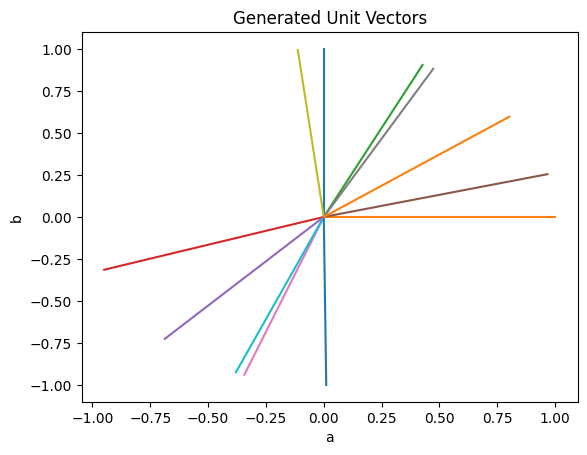

In [276]:
n_dim = 2
n_random_vectors = 10

vectors = []

# Generate Basis Vectors
v1 = np.array([0,1])
v2 = np.array([1,0])

vectors.extend([v1, v2])

for _ in range(n_random_vectors):
    rand_vec = np.random.uniform(-1, 1) * v1 + np.random.uniform(-1, 1) * v2 # Create random linear combination of basis vectors
    rand_vec /= np.linalg.norm(rand_vec)    # Normalise to create unit vector
    vectors.extend(np.array([rand_vec]))

vectors = np.array(vectors)

# Plot the vectors
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title("Generated Unit Vectors")
ax.set_xlabel("a")
ax.set_ylabel("b")

for i in range(len(vectors)):
    ax.plot([0, vectors[i, 0]], [0, vectors[i, 1]])


Text(0, 0.5, 'b')

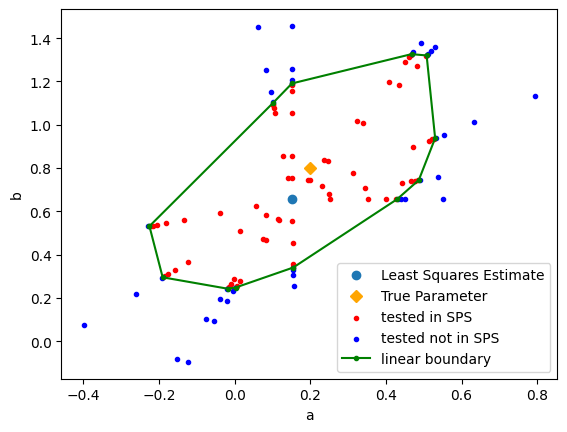

In [277]:

def test_one_direction(unit_vector, lse, starting_radius=0.1, epsilon=0.01, max_tries=100):
    # scale the vector
    radius = starting_radius
    theta = np.arctan2(unit_vector[1], unit_vector[0])

    a0 = lse[0]
    b0 = lse[1]

    attempt_no = 0

    highest_true = None
    lowest_false = None

    current_error = 1

    ins = []
    outs = []
    boundary = None

    while current_error > epsilon and attempt_no < max_tries:
        attempt_no += 1
        a = a0 + radius * np.cos(theta)
        b = b0 + radius * np.sin(theta)
        try:
            in_sps = sps_test_function( (a,b), U[0:100], Y[0:100])
        except:
            in_sps = False

        # Update search params
        if in_sps:
            ins.append(np.array([a, b]))
            highest_true = radius

            if lowest_false:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius *= 2

        else:
            outs.append(np.array([a, b]))
            lowest_false = radius

            if highest_true:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius /= 2

        if highest_true and lowest_false:
            current_error = lowest_false - highest_true

    boundary = (a0 + radius * np.cos(theta), b0 + radius * np.sin(theta))
    return (ins, outs, boundary)


# Plot data
ins = []
outs = []
boundaries = []

# Sort the vectors according to angle
vectors = sorted(vectors, key=lambda x: (np.arctan2(x[1], x[0])))


for vector in vectors:
    new_ins, new_outs, boundary= test_one_direction(vector, params_ls)
    ins.extend(new_ins)
    outs.extend(new_outs)
    boundaries.append(boundary)

a0 = params_ls[0]
b0 = params_ls[1]

fig, ax = plt.subplots()

ins = np.array(ins)
outs = np.array(outs)
boundaries.append(boundaries[0])
boundaries = np.array(boundaries)

ax.plot(a0, b0, 'o', label="Least Squares Estimate")
ax.plot(a1_true, b1_true, 'D', c='orange', label="True Parameter", )

if len(ins) > 0:
    ax.scatter(ins[:, 0], ins[:, 1], marker='.', c='red', label="tested in SPS")
if len(outs) > 0:
    ax.scatter(outs[:, 0], outs[:, 1], marker='.', c='blue', label="tested not in SPS")
if len(boundaries) > 0:
    ax.plot(boundaries[:, 0], boundaries[:, 1], marker='.', c='green', label="linear boundary")
ax.legend()

# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
ax.set_xlabel("a")
ax.set_ylabel("b")